In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [4]:
#1. Set up
df = pd.read_csv('train.csv')

# define targets and features
target_col = 'market_forward_excess_returns'
# Define columns to drop from the feature set (X)
# 1. date_id: Just an identifier, contains no market signal.
# 2. forward_returns: Future data (Look-ahead Bias). Using it would be cheating.
# 3. risk_free_rate: Not available in the test set (as per competition rules).
# 4. market_forward_excess_returns: The target label (Y). This is what we predict.
ignore_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
feature_cols = [c for c in df.columns if c not in ignore_cols]

In [5]:
# 2. Data Split
# Simple imputation for missing values (Forward Fill -> Fill with 0)
# Note: Forward fill is suitable for time-series data.
X_all = df[feature_cols].ffill().fillna(0)
y_all = df[target_col]

# Time Series Split (First 80% Train, Last 20% Validation)
# Strict temporal splitting to prevent future data leakage.
split = int(len(df) * 0.8)
X_train, X_val = X_all.iloc[:split], X_all.iloc[split:]
y_train, y_val = y_all.iloc[:split], y_all.iloc[split:]

In [6]:
# 3. define a training experiment with a specific feature engineering pipeline.

def run_experiment(name, pipeline):

    print(f"\n--- Running Experiment: {name} ---")

    # A. Feature Engineering
    # CRITICAL: Fit the pipeline ONLY on the training set to avoid leakage.
    if pipeline:
        print("  Applying feature transformation...")
        X_train_trans = pipeline.fit_transform(X_train)
        # Transform validation set using the rules learned from training set
        X_val_trans = pipeline.transform(X_val)
    else:
        # No pipeline (Baseline): Use raw features
        X_train_trans, X_val_trans = X_train, X_val

    print(f"  Feature dimensions after transformation: {X_train_trans.shape[1]}")

    # B. Model Training (LightGBM)
    print("  Training LightGBM model...")

    # Simplified parameters for quick experimentation
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'seed': 42,
        'learning_rate': 0.05,
        'num_leaves': 31
    }

    dtrain = lgb.Dataset(X_train_trans, label=y_train)
    dval = lgb.Dataset(X_val_trans, label=y_val, reference=dtrain)

    # Train with early stopping
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dval],
        num_boost_round=500,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(0) # Suppress verbose logs
        ]
    )

    # C. Evaluation
    # Calculate Information Coefficient (IC) - Correlation between preds and actuals
    preds = model.predict(X_val_trans)
    ic = np.corrcoef(preds, y_val)[0, 1]
    print(f"  ✅ Validation IC Score: {ic:.4f}")

    return ic

In [7]:
# 4. Run Experiments
results = {}

# Experiment 1: Baseline (Raw Features)
# Use all original features without any transformation.
results['Baseline (Raw)'] = run_experiment(
    "Baseline (Raw Features)",
    pipeline=None
)

# Experiment 2: PCA (Principal Component Analysis)
# Standardize features -> Reduce to components explaining 95% variance.
pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42))
])
results['PCA (95% Variance)'] = run_experiment(
    "PCA (Scaling + Dimensionality Reduction)",
    pipeline=pca_pipe
)

# Experiment 3: Feature Clustering
# Force clustering of 90+ features into 20 representative features.
cluster_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('cluster', FeatureAgglomeration(n_clusters=20))
])
results['Feature Clustering'] = run_experiment(
    "Clustering (Feature Agglomeration)",
    pipeline=cluster_pipe
)


--- Running Experiment: Baseline (Raw Features) ---
  Feature dimensions after transformation: 94
  Training LightGBM model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111246
  ✅ Validation IC Score: -0.0449

--- Running Experiment: PCA (Scaling + Dimensionality Reduction) ---
  Applying feature transformation...
  Feature dimensions after transformation: 46
  Training LightGBM model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0111065
  ✅ Validation IC Score: 0.0414

--- Running Experiment: Clustering (Feature Agglomeration) ---
  Applying feature transformation...
  Feature dimensions after transformation: 20
  Training LightGBM model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.0111021
  ✅ Validation IC Score: 0.0471


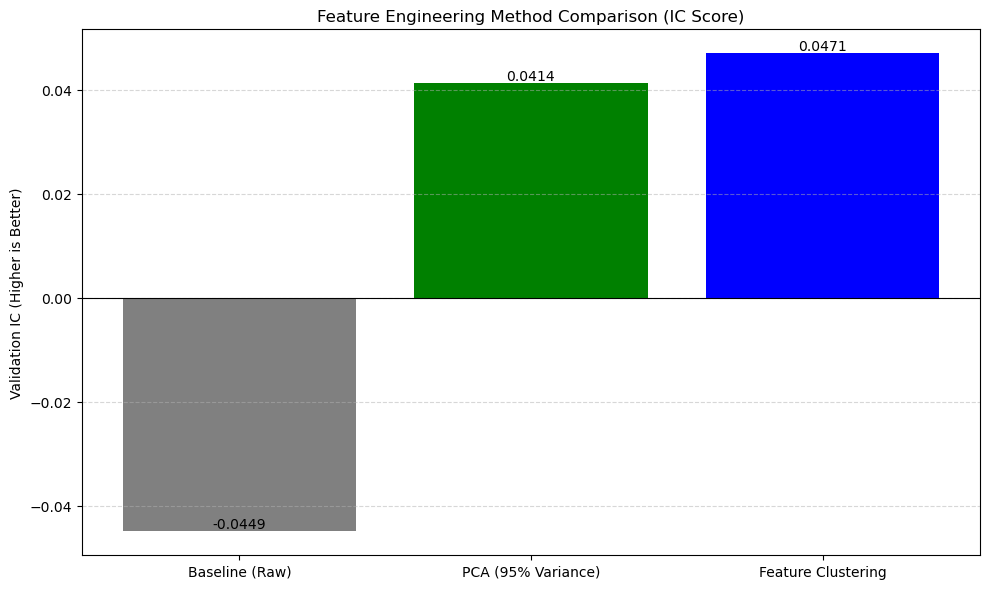

In [8]:
# 5. Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=['gray', 'green', 'blue'])
plt.title('Feature Engineering Method Comparison (IC Score)')
plt.ylabel('Validation IC (Higher is Better)')
plt.axhline(0, color='black', linewidth=0.8)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()